In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.pyfunc


In [3]:
path = '../neondb_00_RAW_00_IESO_DEMAND.csv'
data = pd.read_csv(path)

In [4]:
data.head()

,date,timestamp,Ontario_Demand,Market_Demand
0,2025-09-19,2025-09-19 01:00:00.000000,14222,16687
1,2025-09-18,2025-09-18 01:00:00.000000,13958,16192
2,2025-09-17,2025-09-17 01:00:00.000000,13664,16007
3,2025-09-16,2025-09-16 01:00:00.000000,13717,16022
4,2025-09-15,2025-09-15 01:00:00.000000,13570,15784


In [5]:
df = data.sort_values('timestamp', ascending=True)

In [6]:
df

,date,timestamp,Ontario_Demand,Market_Demand
6161,2025-01-01,2025-01-01 01:00:00.000000,13887,17247
6160,2025-01-01,2025-01-01 02:00:00.000000,13722,17355
6148,2025-01-01,2025-01-01 03:00:00.000000,13688,17638
6171,2025-01-01,2025-01-01 04:00:00.000000,13613,17065
6170,2025-01-01,2025-01-01 05:00:00.000000,13593,17498
...,...,...,...,...
4,2025-09-15,2025-09-15 01:00:00.000000,13570,15784
3,2025-09-16,2025-09-16 01:00:00.000000,13717,16022
2,2025-09-17,2025-09-17 01:00:00.000000,13664,16007
1,2025-09-18,2025-09-18 01:00:00.000000,13958,16192


In [7]:

# -----------------------
# 2. Split train/test
# -----------------------
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [8]:
train_df

,date,timestamp,Ontario_Demand,Market_Demand
6161,2025-01-01,2025-01-01 01:00:00.000000,13887,17247
6160,2025-01-01,2025-01-01 02:00:00.000000,13722,17355
6148,2025-01-01,2025-01-01 03:00:00.000000,13688,17638
6171,2025-01-01,2025-01-01 04:00:00.000000,13613,17065
6170,2025-01-01,2025-01-01 05:00:00.000000,13593,17498
...,...,...,...,...
1240,2025-07-25,2025-07-25 14:00:00.000000,22357,24209
1239,2025-07-25,2025-07-25 15:00:00.000000,22646,24597
1238,2025-07-25,2025-07-25 16:00:00.000000,23029,25007
1237,2025-07-25,2025-07-25 17:00:00.000000,23055,24721


In [ ]:
# -----------------------
# 3. Start MLflow run
# -----------------------
mlflow.set_experiment("time_series_arima")
with mlflow.start_run():

    # -----------------------
    # 4. Train ARIMA model
    # -----------------------
    # p, d, q are ARIMA hyperparameters; you can tune them
    model = ARIMA(train_df['Ontario_Demand'], order=(5,1,0))  # example order
    model_fit = model.fit()

    # -----------------------
    # 5. Make predictions
    # -----------------------
    start = len(train_df)
    end = len(train_df) + len(test_df) - 1
    forecast = model_fit.predict(start=start, end=end, typ='levels')

    # -----------------------
    # 6. Evaluate
    # -----------------------
    y_true = test_df['Ontario_Demand'].values
    y_pred = forecast.values
    rmse = mean_squared_error(y_true, y_pred)
    print(f"Test RMSE: {rmse}")

    # -----------------------
    # 7. Log model and metrics to MLflow
    # -----------------------
    mlflow.statsmodels.log_model(model_fit, "arima_model")
    mlflow.log_metric("rmse", rmse)
    mlflow.log_param("order", (5,1,0))
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", len(test_df))

print("MLflow run finished. Model logged!")

In [10]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pickle

In [58]:
# Step 2: Create a simple time series DataFrame
df = train_df[['timestamp','Ontario_Demand']]
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

# Step 3: Train ARIMA model
model = ARIMA(df['Ontario_Demand'], order=(24*7,1,1))  # simple example
model_fit = model.fit()

# Step 4: Print summary
print(model_fit.summary())

# ---------------------------
# Step 5: Save the model
# ---------------------------
with open('../tests/arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)
print("Model saved as arima_model.pkl")




/opt/anaconda3/envs/airflow-docker/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/airflow-docker/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/airflow-docker/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/airflow-docker/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

                               SARIMAX Results                                
Dep. Variable:         Ontario_Demand   No. Observations:                 4937
Model:               ARIMA(168, 1, 1)   Log Likelihood              -33130.802
Date:                Fri, 19 Sep 2025   AIC                          66601.604
Time:                        17:24:52   BIC                          67707.337
Sample:                             0   HQIC                         66989.399
                               - 4937                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2099      0.100      2.093      0.036       0.013       0.406
ar.L2          0.0202      0.049      0.416      0.678      -0.075       0.115
ar.L3         -0.0529      0.017     -3.091      0.0

In [12]:
# ---------------------------
# Step 6: Load the model
# ---------------------------

model_path = 'model.pkl'
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)
print("Model loaded successfully")

# Step 7: Forecast using loaded model
forecast = loaded_model.forecast(steps=24*30)
print("Forecast from loaded model:\n", forecast)



ModuleNotFoundError: No module named 'azureml.training'

/var/folders/9t/ywq9gg3s4zbgn2zw5tfskbv00000gn/T/ipykernel_37356/4178556105.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(start=df.index[-1]+pd.offsets.Hour(1), periods=24*30, freq='H'),


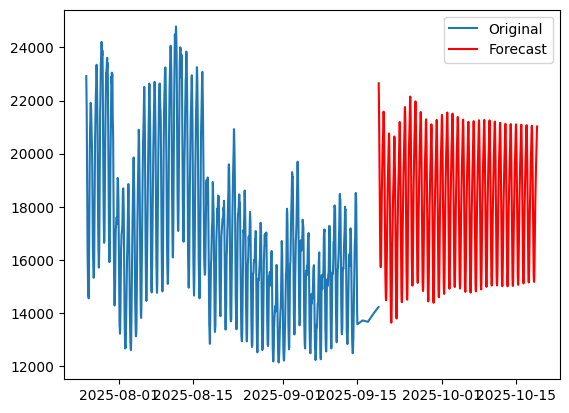

In [60]:
# Step 8: Plot original series and forecast
df = test_df[['timestamp','Ontario_Demand']]
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

plt.plot(df['Ontario_Demand'], label='Original')
plt.plot(pd.date_range(start=df.index[-1]+pd.offsets.Hour(1), periods=24*30, freq='H'),
         forecast, label='Forecast', color='red')
plt.legend()
plt.show()